<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/MultiModel_images_ferramenta_ResNet_101_100_images10_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Testing Multi-model performance for 100% images and _% text.
# Updated Validation Dataset Class and Validation Loop

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report
# import patoolib

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Mount Drive

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# !gdown https://drive.google.com/uc?id=1p1qz1lDDwqrW-lTa11liOBMuWwIT8IP4

In [ ]:
# path = "/content/text_encodings-images-train.rar"

In [ ]:
# patoolib.extract_archive(path, outdir="/content/Data/")

In [ ]:
# import zipfile

# with zipfile.ZipFile("/content/mulitmodal_img_enc_txt.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/Data/")

# Extract Images

In [ ]:
# path = "/content/images-train.tar.gz"
# images-train.tar.gz
# images-val.tar.gz

In [ ]:
# os.chdir(path)

In [ ]:
# path = "/content/images-train.tar.gz"
# import tarfile

# with tarfile.open(path, 'r:gz') as tar_ref:
#     tar_ref.extractall('trainImages')

# Loading Training Dataset and Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/Data/mulitmodal_img_enc_txt/images-train"
dataset = FragmentaDataset(data_dir)

In [ ]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

In [ ]:
batch_size = 32
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()


# Loading ResNet-101

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # 52 is the number of classes in your dataset
resnet.to(device)
print(resnet)

# Fine Tuning

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 30

In [ ]:
training_loss = []
resnet.train()

for epoch in range(num_epochs):
    # Set the model to training mode
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save and Download Model

In [ ]:
# save_dir = "/content/Model/ResNet_Joint_Representation/"
# os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
# torch.save(resnet.state_dict(), save_path)

In [ ]:
# !zip -r /content/ResNet_MultiModel.zip /content/Model/ResNet_MultiModel

In [ ]:
# from google.colab import files
# files.download("/content/ResNet_MultiModel.zip")

# Loading Validation Dataset and Preprocessing

In [3]:
save_dir = '/content/Model/ResNet_MultiModel'
load_path = os.path.join(save_dir, 'model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 52)

# Load the saved model parameters
resnet.load_state_dict(torch.load(load_path))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, val_transform):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir)
        self.classes = self.dataset.classes
        self.class_lengths = self._compute_class_lengths()
        self.val_transform = val_transform

        # Load only 50% of data from each class
        self.selected_indices = []
        for class_idx in range(len(self.classes)):
            indices = [idx for idx, (_, label) in enumerate(self.dataset.samples) if label == class_idx]
            indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
            indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

            # Include all files ending with "_4.png"
            self.selected_indices.extend(indices_4)

            # Randomly select 50% of files ending with "_3.png"
            num_samples_3 = len(indices_3)
            num_samples_to_load_3 = int(0.1 * num_samples_3) # change the value to change percentage of data <<<<<<<<<<<<<
            selected_indices_3 = np.random.choice(indices_3, num_samples_to_load_3, replace=False)

            # Append the selected indices to the selected_indices list
            self.selected_indices.extend(selected_indices_3)

        print("Selected Indices:", len(self.selected_indices))
        # for idx in self.selected_indices:
          # print(self.dataset.samples[idx][0])

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for _, label in self.dataset.samples:
            class_lengths[self.classes[label]] += 1

        return class_lengths

    def __getitem__(self, index):
        image_3, label = self.dataset[self.selected_indices[index]]
        filename = self.dataset.samples[self.selected_indices[index]][0]
        image_4_path = filename.replace('_3.png', '_4.png')
        if image_4_path in [self.dataset.samples[idx][0] for idx in self.selected_indices]:
            image_4 = self._load_image(image_4_path)
        else:
            image_4 = None
        return image_3, image_4, label

    def _load_image(self, path):
        image = Image.open(path)
        return image

    def __len__(self):
        return len(self.selected_indices)

In [6]:
valPath = "/content/Data/mulitmodal_img_enc_txt/images-val"
val_dataset = ValidationDataset(valPath,val_transform)

Selected Indices: 24031


In [7]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 24031
Number of classes: 52


In [8]:
from torchvision.transforms import ToTensor

def custom_collate(batch):
    to_tensor = ToTensor()

    images_3 = [to_tensor(item[0]) for item in batch]
    images_4 = [to_tensor(item[1]) if item[1] is not None else None for item in batch]
    labels = [torch.tensor(item[2]) for item in batch]  # Convert labels to tensors

    # Filter out None values from images_4
    images_4 = [img for img in images_4 if img is not None]

    # Convert the list of images to tensors
    images_3 = torch.stack(images_3) if images_3 else None
    images_4 = torch.stack(images_4) if images_4 else None

    return images_3, images_4, labels



In [9]:
batch_size = 12
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

In [ ]:
class_lengths_dict = val_dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

In [ ]:
#  Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()

# Validation

In [10]:
resnet.eval()

# Initialize lists to store the average probabilities and true labels
predicted_labels = []
true_labels = []

# Iterate over the dataloader in your testing loop
for images_3, images_4, labels in validation_data_loader:
    # Move the images and labels to the device (e.g., GPU) if available
    images_3 = images_3.to(device)
    # labels = labels.to(device)


    # Check if images_4 is None
    if images_4 is not None:
        images_4 = images_4.to(device)
        # Perform the forward pass on the model to obtain the logits
        logits_4 = resnet(images_4)
    else:
        # If images_4 is None, set logits_4 as all zeros
        logits_4 = torch.zeros_like(logits_3)

    # Perform the forward pass on the model to obtain the logits
    logits_3 = resnet(images_3)

    # Compute the probabilities using softmax along the class dimension
    probabilities_3 = torch.softmax(logits_3, dim=1)
    probabilities_4 = torch.softmax(logits_4, dim=1)

    # Average the probabilities for each pair
    avg_probabilities_batch = (probabilities_3 + probabilities_4) / 2

    # Append the average probabilities to the list
    predicted_labels.extend(avg_probabilities_batch.cpu().tolist())

    # labels = torch.tensor(labels).to(device)
    # Append the true labels to the list
    true_labels.extend(labels)


In [11]:
predicted_classes = torch.argmax(torch.tensor(predicted_labels), dim=1)
actual_labels = torch.tensor(true_labels)

In [12]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7997170321667846
Precision: 0.8403772140979782
Recall: 0.7997170321667846
F1-score: 0.8002011608504171


In [13]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.09      0.20      0.12        64
           1       0.99      0.41      0.58      2066
           2       0.87      0.72      0.79       379
           3       0.92      0.63      0.75        52
           4       0.98      0.92      0.95       145
           5       0.88      0.67      0.76       193
           6       0.83      0.96      0.89      1175
           7       0.89      0.95      0.92       162
           8       0.74      0.84      0.79       729
           9       0.86      0.97      0.91       706
          10       0.39      0.89      0.54       149
          11       0.89      0.66      0.76        38
          12       0.97      0.46      0.63       123
          13       0.86      0.73      0.79       926
          14       0.93      0.97      0.95      1710
          15       0.52      0.64      0.57        39
          16       0.29      0.93      0.45        56
          17       0.82    

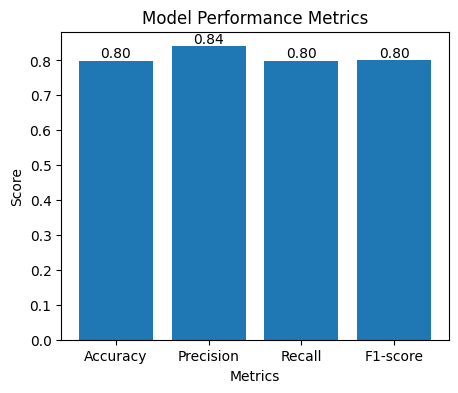

In [14]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

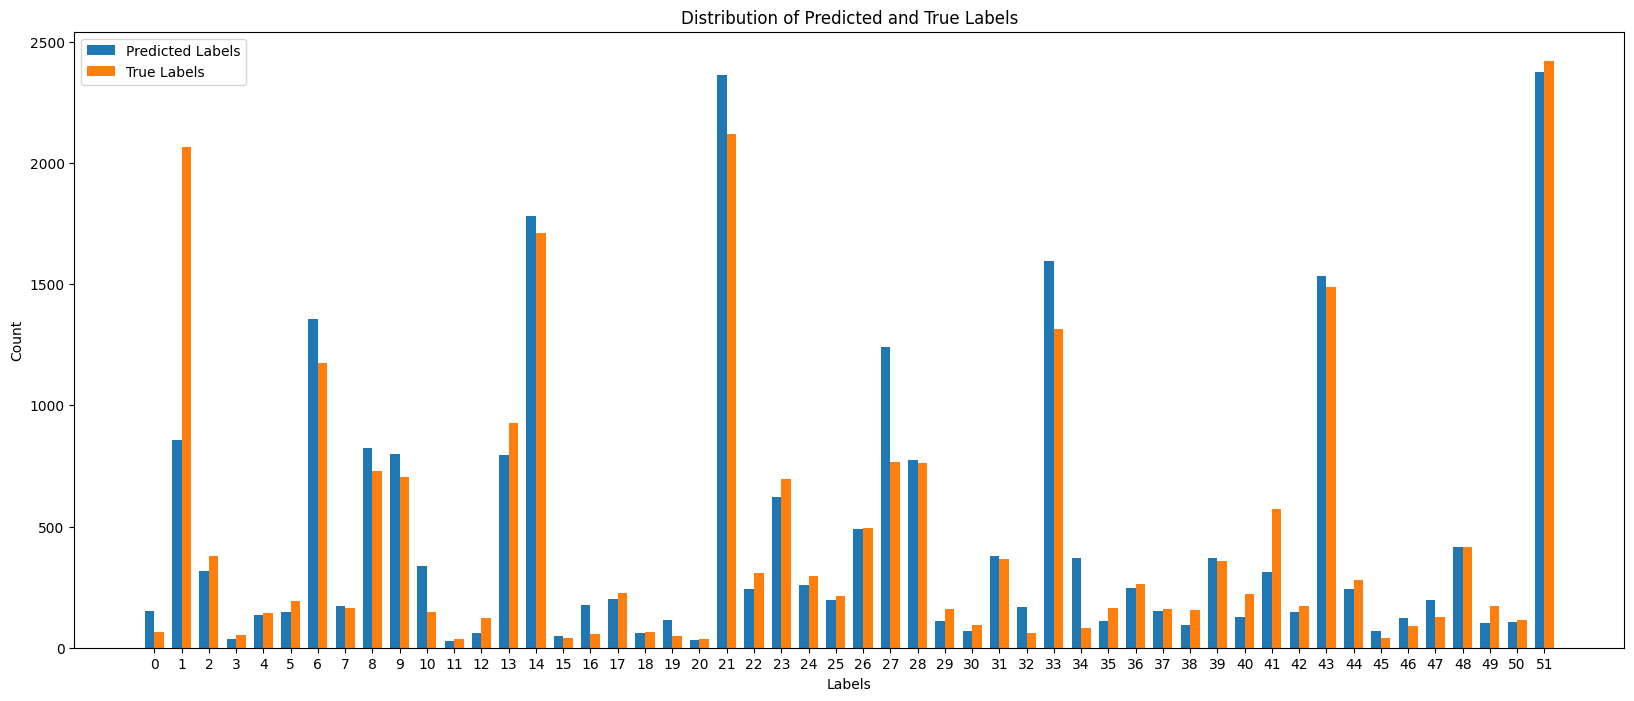

In [15]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()